# EDA

## Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import string
import re
import os
import json


In [2]:
# Load the JSON file
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATASET_FOLDER = os.path.join(BASE_DIR, 'data')
JSON_FILE = os.path.join(DATASET_FOLDER, 'eos_final.json')
data = pd.read_json(JSON_FILE)
data = data.iloc[:-1]


In [3]:
# Clean the data
data['publication_date'] = pd.to_datetime(data['publication_date'])
data['signing_date'] = pd.to_datetime(data['signing_date'])

def extract_president_name(value):
    if isinstance(value, str):
        try:
            # Parse the string as JSON and extract the 'name' key
            return json.loads(value).get('name', value)
        except json.JSONDecodeError:
            # If the string is not JSON, return it as-is
            return value
    return value

data['president'] = data['president'].apply(extract_president_name)

data['executive_order_number'] = data['executive_order_number'].apply(
    lambda x: str(int(x)) if pd.notnull(x) else x
)


In [4]:
def clean_toc_subject(entry):
    if pd.isnull(entry):
        return "Unspecified"
    cleaned = entry.replace(":", "").strip()
    cleaned = re.sub(r"(\w+), Department of", r"Department of \1", cleaned)
    cleaned = cleaned.split(",")[0] if "," in cleaned else cleaned
    return cleaned

data['toc_subject'] = data['toc_subject'].apply(clean_toc_subject)
data.head()


,title,president,publication_date,signing_date,citation,document_number,executive_order_number,pdf_url,toc_subject,disposition_notes,full_text
0,Combating Emerging Firearms Threats and Improv...,Joseph R. Biden Jr.,2024-10-02,2024-09-26,89 FR 80345,2024-22938,14127,https://www.govinfo.gov/content/pkg/FR-2024-10...,Unspecified,None,The President Executive Order 14127 of Septemb...
1,Investing in America and Investing in American...,Joseph R. Biden Jr.,2024-09-11,2024-09-06,89 FR 73559,2024-20712,14126,https://www.govinfo.gov/content/pkg/FR-2024-09...,Federal Government,"See: EO 11246, September 24, 1965; EO 13985, J...","Executive Order 14126 of September 6, 2024 Inv..."
2,Establishing an Emergency Board To Investigate...,Joseph R. Biden Jr.,2024-07-29,2024-07-24,89 FR 60791,2024-16740,14125,https://www.govinfo.gov/content/pkg/FR-2024-07...,Committees; Establishment,None,"Executive Order 14125 of July 24, 2024 Establi..."
3,White House Initiative on Advancing Educationa...,Joseph R. Biden Jr.,2024-07-22,2024-07-17,89 FR 59585,2024-16225,14124,https://www.govinfo.gov/content/pkg/FR-2024-07...,Education,"See: EO 14045, September 13, 2021",The President Executive Order 14124 of July 17...
4,White House Council on Supply Chain Resilience,Joseph R. Biden Jr.,2024-06-21,2024-06-14,89 FR 51949,2024-13810,14123,https://www.govinfo.gov/content/pkg/FR-2024-06...,Committees; Establishment,"See: EO 14017, February 24, 2021\r\nSupersedes...","Executive Order 14123 of June 14, 2024 White H..."


In [5]:
recent_10_years_data = data[(data['publication_date'] >= '2014-01-01') & (data['signing_date'] >= '2014-01-01')]
recent_10_years_data.head()


,title,president,publication_date,signing_date,citation,document_number,executive_order_number,pdf_url,toc_subject,disposition_notes,full_text
0,Combating Emerging Firearms Threats and Improv...,Joseph R. Biden Jr.,2024-10-02,2024-09-26,89 FR 80345,2024-22938,14127,https://www.govinfo.gov/content/pkg/FR-2024-10...,Unspecified,None,The President Executive Order 14127 of Septemb...
1,Investing in America and Investing in American...,Joseph R. Biden Jr.,2024-09-11,2024-09-06,89 FR 73559,2024-20712,14126,https://www.govinfo.gov/content/pkg/FR-2024-09...,Federal Government,"See: EO 11246, September 24, 1965; EO 13985, J...","Executive Order 14126 of September 6, 2024 Inv..."
2,Establishing an Emergency Board To Investigate...,Joseph R. Biden Jr.,2024-07-29,2024-07-24,89 FR 60791,2024-16740,14125,https://www.govinfo.gov/content/pkg/FR-2024-07...,Committees; Establishment,None,"Executive Order 14125 of July 24, 2024 Establi..."
3,White House Initiative on Advancing Educationa...,Joseph R. Biden Jr.,2024-07-22,2024-07-17,89 FR 59585,2024-16225,14124,https://www.govinfo.gov/content/pkg/FR-2024-07...,Education,"See: EO 14045, September 13, 2021",The President Executive Order 14124 of July 17...
4,White House Council on Supply Chain Resilience,Joseph R. Biden Jr.,2024-06-21,2024-06-14,89 FR 51949,2024-13810,14123,https://www.govinfo.gov/content/pkg/FR-2024-06...,Committees; Establishment,"See: EO 14017, February 24, 2021\r\nSupersedes...","Executive Order 14123 of June 14, 2024 White H..."


## 2- VisualIzations

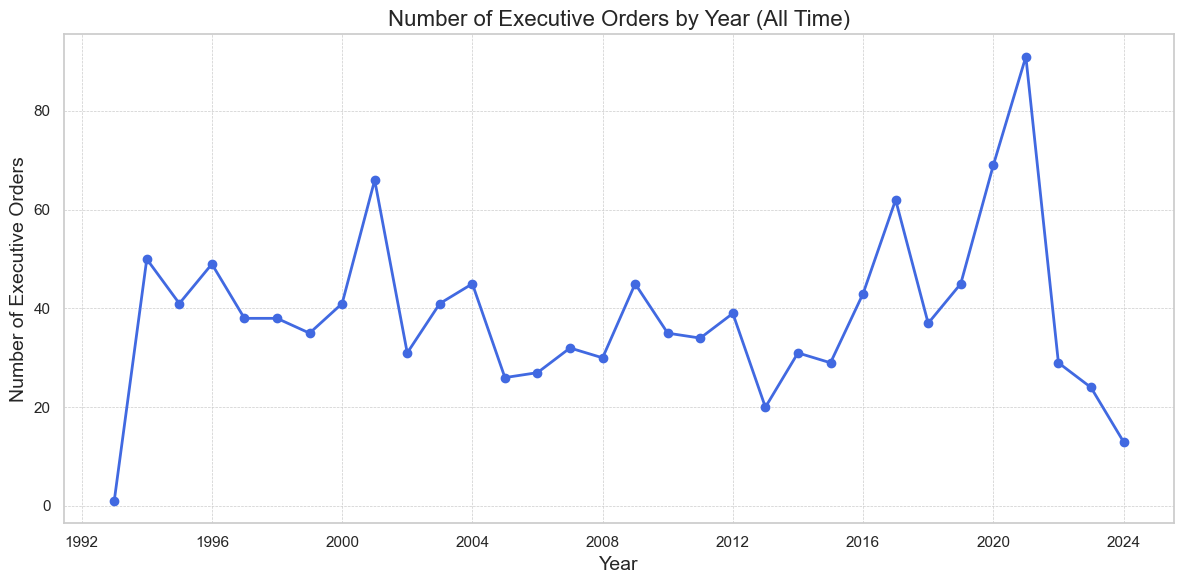

In [6]:
# Number of Executive Orders by Year
data['signing_date'] = pd.to_datetime(data['signing_date'], errors='coerce')
data['year'] = data['signing_date'].dt.year
yearly_counts = data.groupby('year').size()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(yearly_counts.index, yearly_counts, marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.title('Number of Executive Orders by Year (All Time)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Executive Orders', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


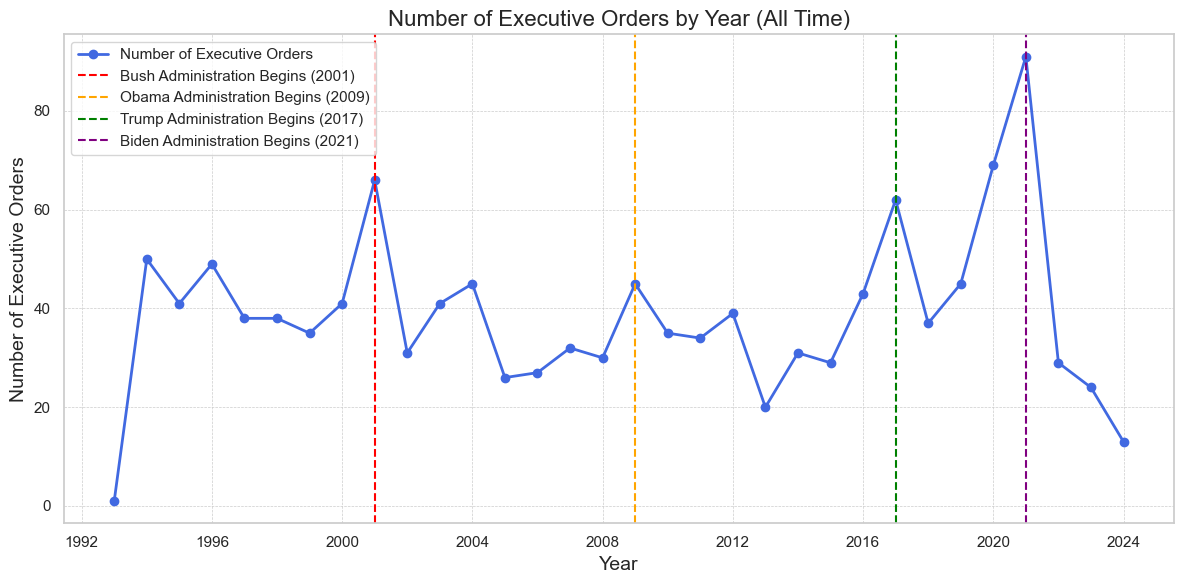

In [7]:
# With labels
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linestyle='-', color='royalblue', linewidth=2, label='Number of Executive Orders')

plt.axvline(x=2001, color='red', linestyle='--', label='Bush Administration Begins (2001)')
plt.axvline(x=2009, color='orange', linestyle='--', label='Obama Administration Begins (2009)')
plt.axvline(x=2017, color='green', linestyle='--', label='Trump Administration Begins (2017)')
plt.axvline(x=2021, color='purple', linestyle='--', label='Biden Administration Begins (2021)')

plt.title('Number of Executive Orders by Year (All Time)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Executive Orders', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1963419614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['signing_date'] = pd.to_datetime(recent_10_years_data['signing_date'], errors='coerce')
/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1963419614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['year'] = recent_10_years_data['signing_date'].dt.year


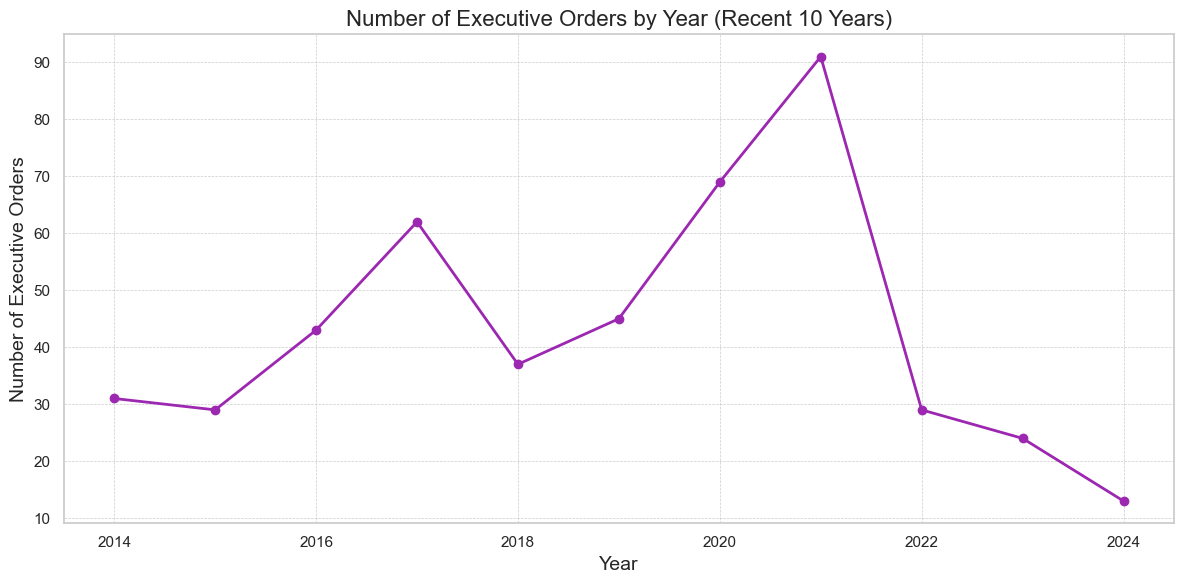

In [8]:
# Number of Executive Orders by Year (Recent 10 Years)
recent_10_years_data['signing_date'] = pd.to_datetime(recent_10_years_data['signing_date'], errors='coerce')
recent_10_years_data['year'] = recent_10_years_data['signing_date'].dt.year
yearly_counts_recent = recent_10_years_data.groupby('year').size()

sns.set(style="whitegrid")

purple = "#9C27B0"

plt.figure(figsize=(12, 6))
plt.plot(yearly_counts_recent.index, yearly_counts_recent.values, marker='o', linestyle='-', color=purple, linewidth=2)
plt.title('Number of Executive Orders by Year (Recent 10 Years)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Executive Orders', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


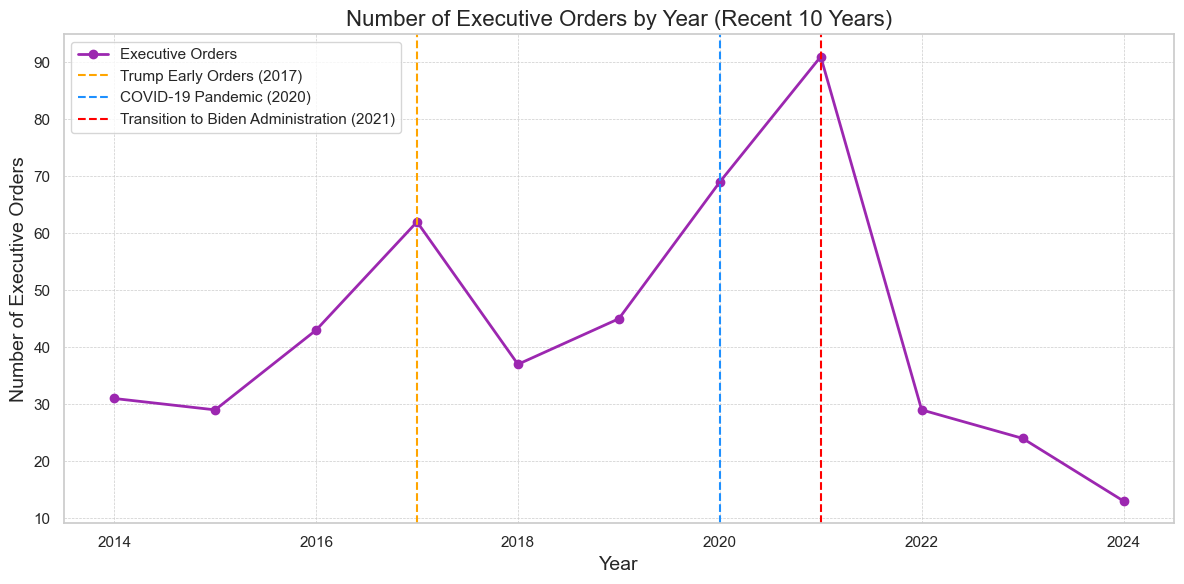

In [9]:
# With labels
sns.set(style="whitegrid")

plot_color = "#9C27B0"
trump_color = "orange"
covid_color = "dodgerblue"
biden_color = "red"

plt.figure(figsize=(12, 6))
plt.plot(yearly_counts_recent.index, yearly_counts_recent.values, marker='o', linestyle='-', color=plot_color, linewidth=2, label='Executive Orders')

# Adding annotations for key events in the recent 10 years
plt.axvline(x=2017, color=trump_color, linestyle='--', label='Trump Early Orders (2017)')
plt.axvline(x=2020, color=covid_color, linestyle='--', label='COVID-19 Pandemic (2020)')
plt.axvline(x=2021, color=biden_color, linestyle='--', label='Transition to Biden Administration (2021)')

plt.title('Number of Executive Orders by Year (Recent 10 Years)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Executive Orders', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [10]:
# Topic by year
def preprocess(text):
    return text.lower().translate(str.maketrans('', '', string.punctuation))

recent_10_years_data['full_text'] = recent_10_years_data['full_text'].apply(preprocess)

# Count Vectorization
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(recent_10_years_data['full_text'])

# LDA Topic Modeling
n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, learning_decay=0.7, random_state=42)
lda.fit(X)

# Assign Topics to Each Document
topic_labels = lda.transform(X).argmax(axis=1)

topic_names = {
    0: 'Cybersecurity',
    1: 'Artificial Intelligence',
    2: 'Technology',
    3: 'Software',
    4: 'Public Health',
    5: 'Economic Policy'
}

recent_10_years_data['category'] = [topic_names[label] for label in topic_labels]

# Display Texts in Each Topic
for topic_id, topic_name in topic_names.items():
    print(f"\n--- Texts in Topic ({topic_name}) ---")
    topic_texts = recent_10_years_data[recent_10_years_data['category'] == topic_name]['full_text'].head(5)
    for idx, text in enumerate(topic_texts, 1):
        print(f"\nText {idx}:\n{text[:500]}...")

# Grouping by Year and Topic
recent_10_years_data['year'] = pd.to_datetime(recent_10_years_data['signing_date']).dt.year
topic_by_year = recent_10_years_data.groupby(['year', 'category']).size().unstack(fill_value=0)


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1927880466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['full_text'] = recent_10_years_data['full_text'].apply(preprocess)



--- Texts in Topic (Cybersecurity) ---

Text 1:
the president executive order 14118 of march 4 2024 termination of emergency with respect to the situation in zimbabwe by the authority vested in me as president by the constitution and the laws of the united states of america including the international emergency economic powers act 50 usc 1701 et seq the national emergencies act 50 usc 1601 et seq nea and section 301 of title 3 united states code i joseph r biden jr president of the united states of america find that the declaration of a natio...

Text 2:
executive order 14115 of february 1 2024 imposing certain sanctions on persons undermining peace security and stability in the west bank by the authority vested in me as president by the constitution and the laws of the united states of america including the international emergency economic powers act 50 usc 1701 et seq ieepa the national emergencies act 50 usc 1601 et seq nea section 212f and section 215a of the immigration and natio

/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1927880466.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['category'] = [topic_names[label] for label in topic_labels]
/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1927880466.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['year'] = pd.to_datetime(recent_10_years_data['signing_date']).dt.year


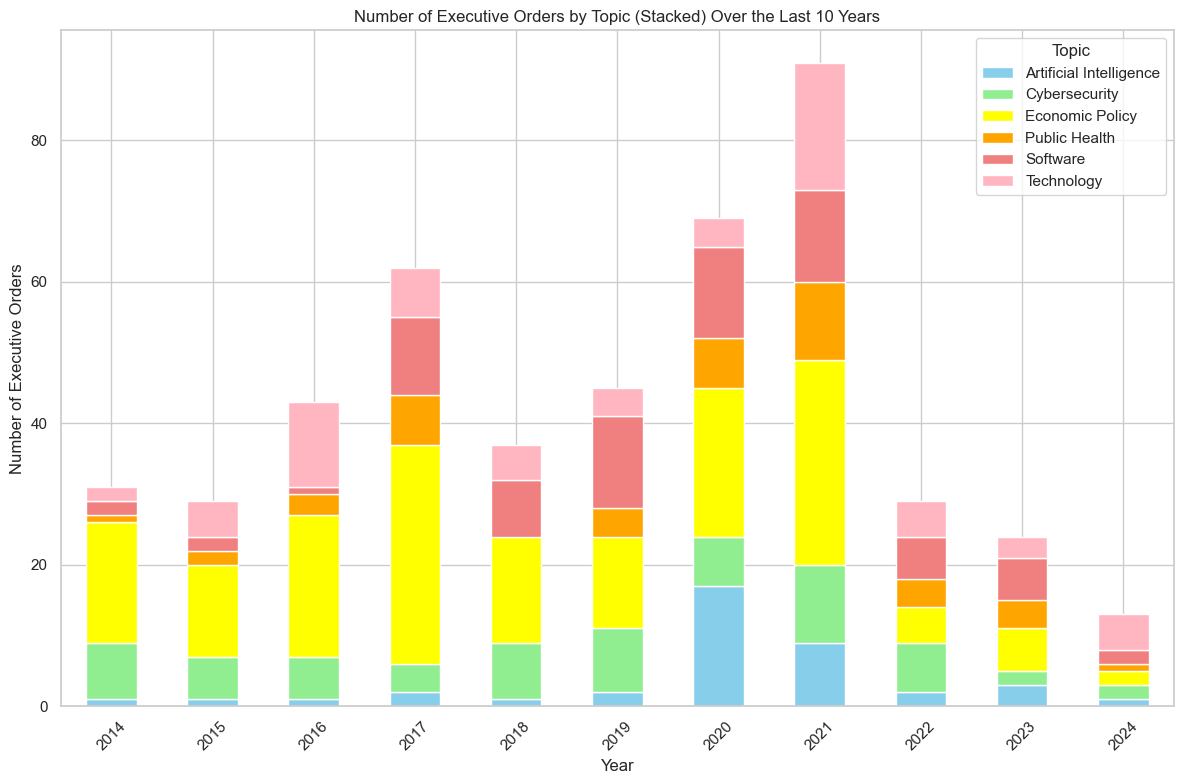

In [11]:
# Generate the Stacked Bar Plot
colors = ['skyblue', 'lightgreen', 'yellow', 'orange', 'lightcoral', 'lightpink']
topic_by_year.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
plt.title('Number of Executive Orders by Topic (Stacked) Over the Last 10 Years')
plt.xlabel('Year')
plt.ylabel('Number of Executive Orders')
plt.xticks(rotation=45)
plt.legend(title='Topic')
plt.tight_layout()
plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/441850633.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_resampled = data.set_index('signing_date').resample('Y')[['revoked', 'supersedes', 'amends', 'memo', 'see']].sum()


<Figure size 1000x600 with 0 Axes>

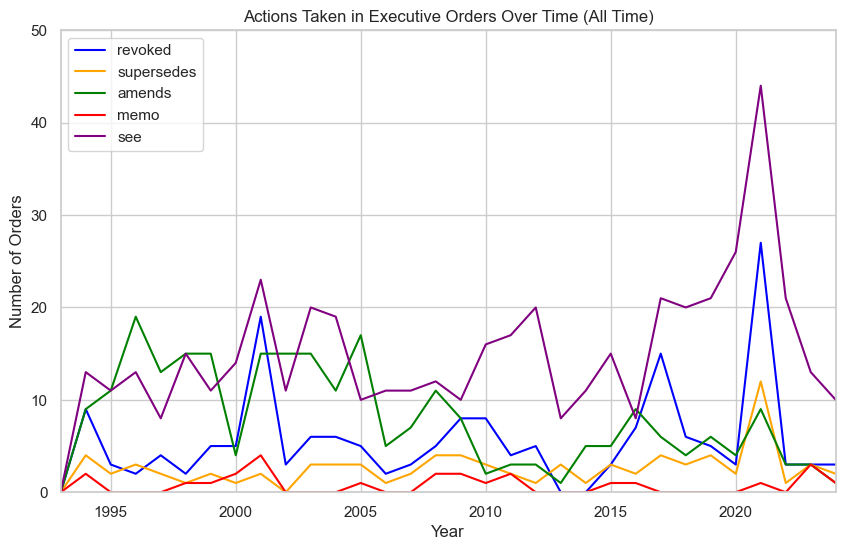

In [12]:
# Create columns based on keywords in 'disposition_notes'
data['revoked'] = data['disposition_notes'].str.contains('Revokes', case=False, na=False).astype(int)
data['supersedes'] = data['disposition_notes'].str.contains('Supersedes', case=False, na=False).astype(int)
data['amends'] = data['disposition_notes'].str.contains('Amends', case=False, na=False).astype(int)
data['memo'] = data['disposition_notes'].str.contains('Memo', case=False, na=False).astype(int)
data['see'] = data['disposition_notes'].str.contains('See', case=False, na=False).astype(int)

plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red', 'purple']

data_resampled = data.set_index('signing_date').resample('Y')[['revoked', 'supersedes', 'amends', 'memo', 'see']].sum()
data_resampled.plot(color=colors, figsize=(10, 6))

plt.ylim(0, 50)

plt.title("Actions Taken in Executive Orders Over Time (All Time)")
plt.ylabel("Number of Orders")
plt.xlabel("Year")
plt.grid(True)

plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/15819383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['revoked'] = recent_10_years_data['disposition_notes'].str.contains('Revokes', case=False, na=False).astype(int)
/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/15819383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['supersedes'] = recent_10_years_data['disposition_notes'].str.contains('Supersedes', case=False, na=False).

<Figure size 1000x600 with 0 Axes>

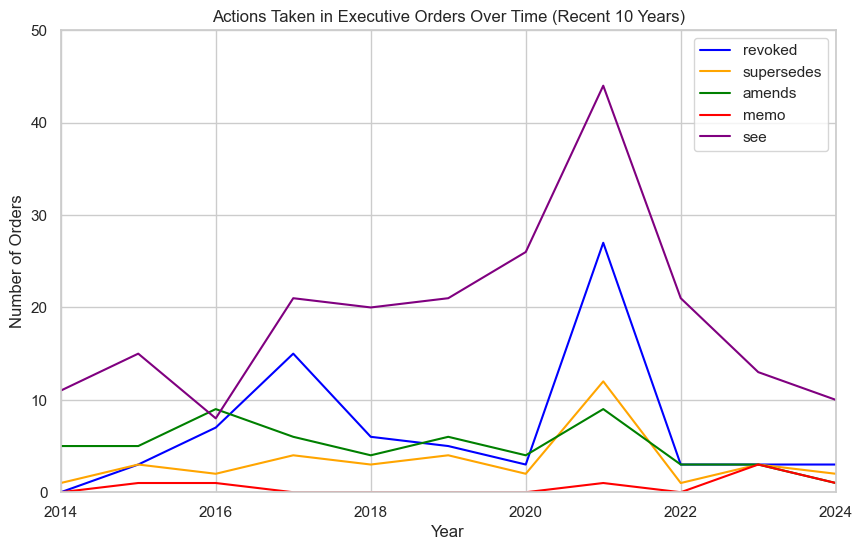

In [13]:
# Create columns based on keywords in 'disposition_notes'
recent_10_years_data['revoked'] = recent_10_years_data['disposition_notes'].str.contains('Revokes', case=False, na=False).astype(int)
recent_10_years_data['supersedes'] = recent_10_years_data['disposition_notes'].str.contains('Supersedes', case=False, na=False).astype(int)
recent_10_years_data['amends'] = recent_10_years_data['disposition_notes'].str.contains('Amends', case=False, na=False).astype(int)
recent_10_years_data['memo'] = recent_10_years_data['disposition_notes'].str.contains('Memo', case=False, na=False).astype(int)
recent_10_years_data['see'] = recent_10_years_data['disposition_notes'].str.contains('See', case=False, na=False).astype(int)

plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red', 'purple']

data_resampled = recent_10_years_data.set_index('signing_date').resample('Y')[['revoked', 'supersedes', 'amends', 'memo', 'see']].sum()
data_resampled.plot(color=colors, figsize=(10, 6))

plt.ylim(0, 50)

plt.title("Actions Taken in Executive Orders Over Time (Recent 10 Years)")
plt.ylabel("Number of Orders")
plt.xlabel("Year")
plt.grid(True)

plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1091843602.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_resampled = data_with_date.resample('Y').sum()


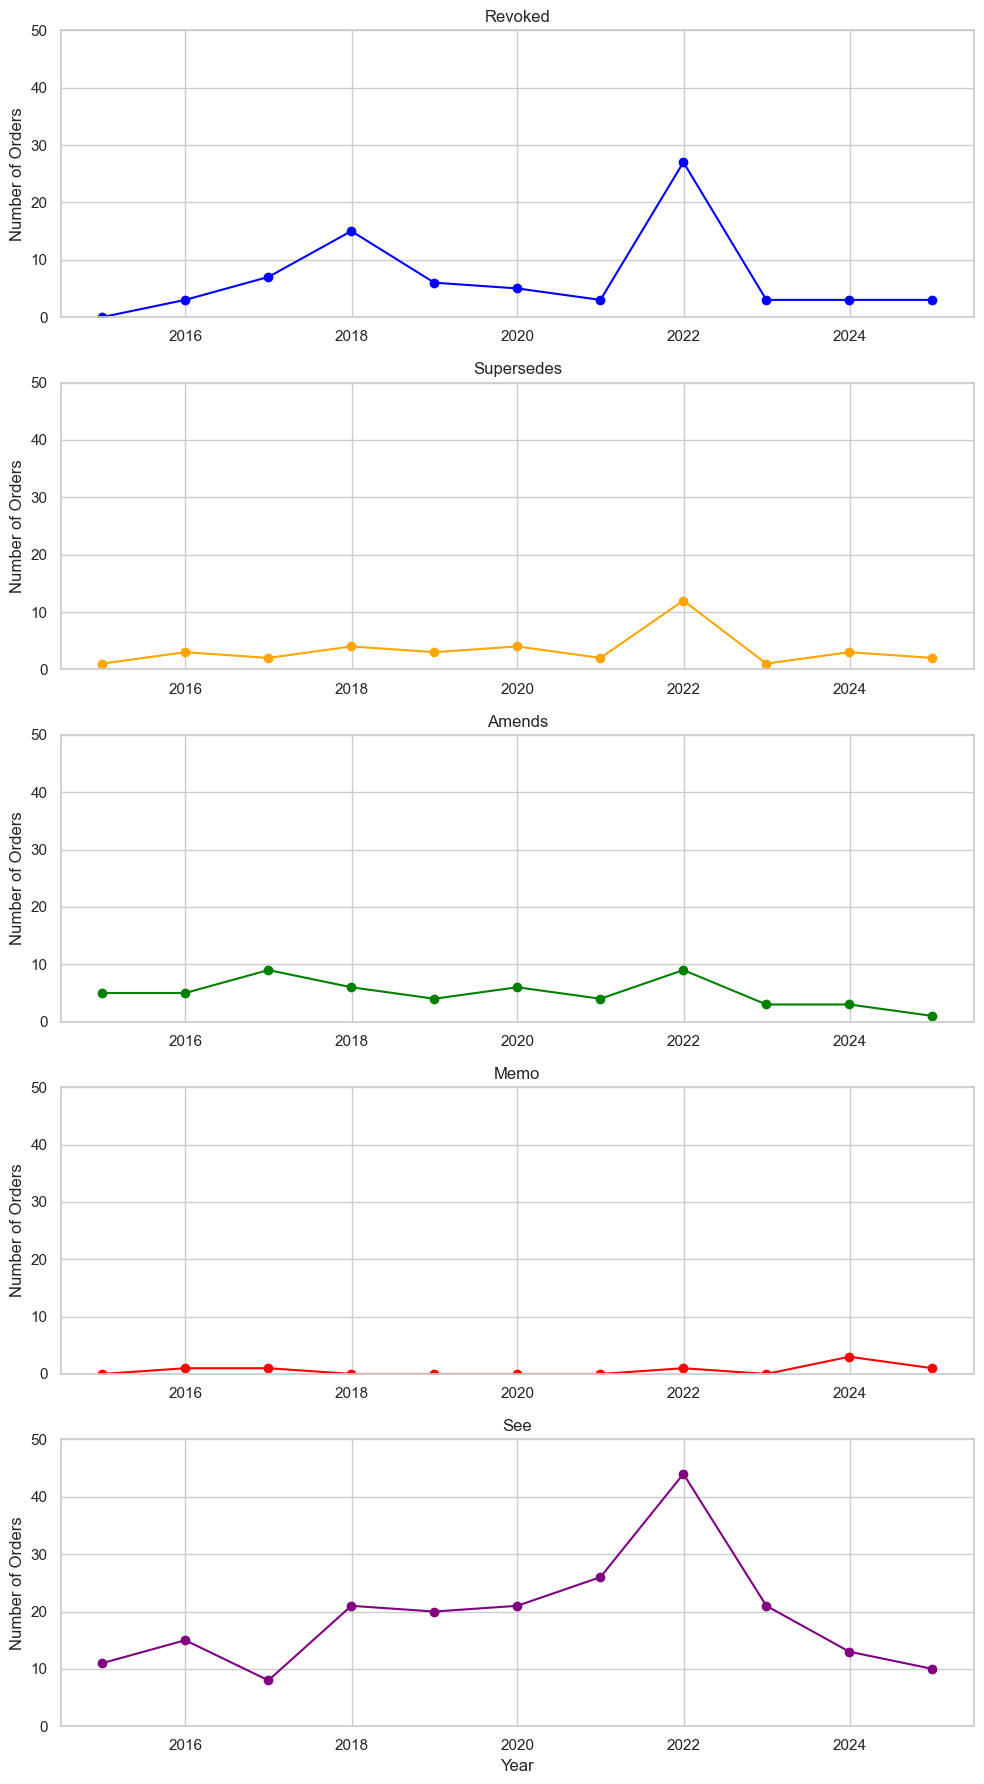

In [14]:
# Generate the plot separately
data_with_date = recent_10_years_data[['signing_date', 'revoked', 'supersedes', 'amends', 'memo', 'see']].set_index('signing_date')
data_resampled = data_with_date.resample('Y').sum()

fig, axs = plt.subplots(5, 1, figsize=(10, 18))
actions = ['revoked', 'supersedes', 'amends', 'memo', 'see']
titles = ['Revoked', 'Supersedes', 'Amends', 'Memo', 'See']
colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, ax in enumerate(axs):
    ax.plot(data_resampled.index, data_resampled[actions[i]], label=titles[i], marker='o', linestyle='-', color=colors[i])
    ax.set_title(titles[i])
    ax.set_ylabel('Number of Orders')
    ax.grid(True)
    ax.set_ylim([0, 50])

axs[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/702919782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['text_length'] = recent_10_years_data['full_text'].str.len()
/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/702919782.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_cleaned.set_index('signing_date').resample('Y')['text_length'].mean().plot(


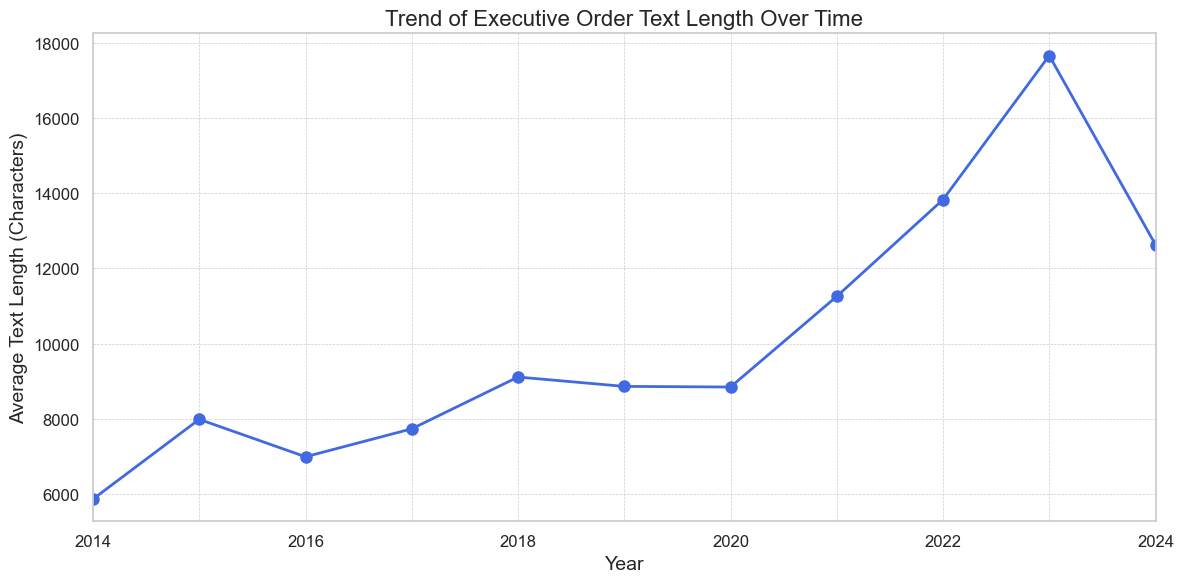

In [15]:
# Trend of Executive Order Text Length Over Time
sns.set(style="whitegrid")

recent_10_years_data['text_length'] = recent_10_years_data['full_text'].str.len()
data_cleaned = recent_10_years_data[recent_10_years_data['text_length'] > 0]

plt.figure(figsize=(12, 6))
data_cleaned.set_index('signing_date').resample('Y')['text_length'].mean().plot(
    color='royalblue', linewidth=2, marker='o', markersize=8)

plt.title('Trend of Executive Order Text Length Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Text Length (Characters)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/1477013346.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['sentiment'] = recent_10_years_data['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


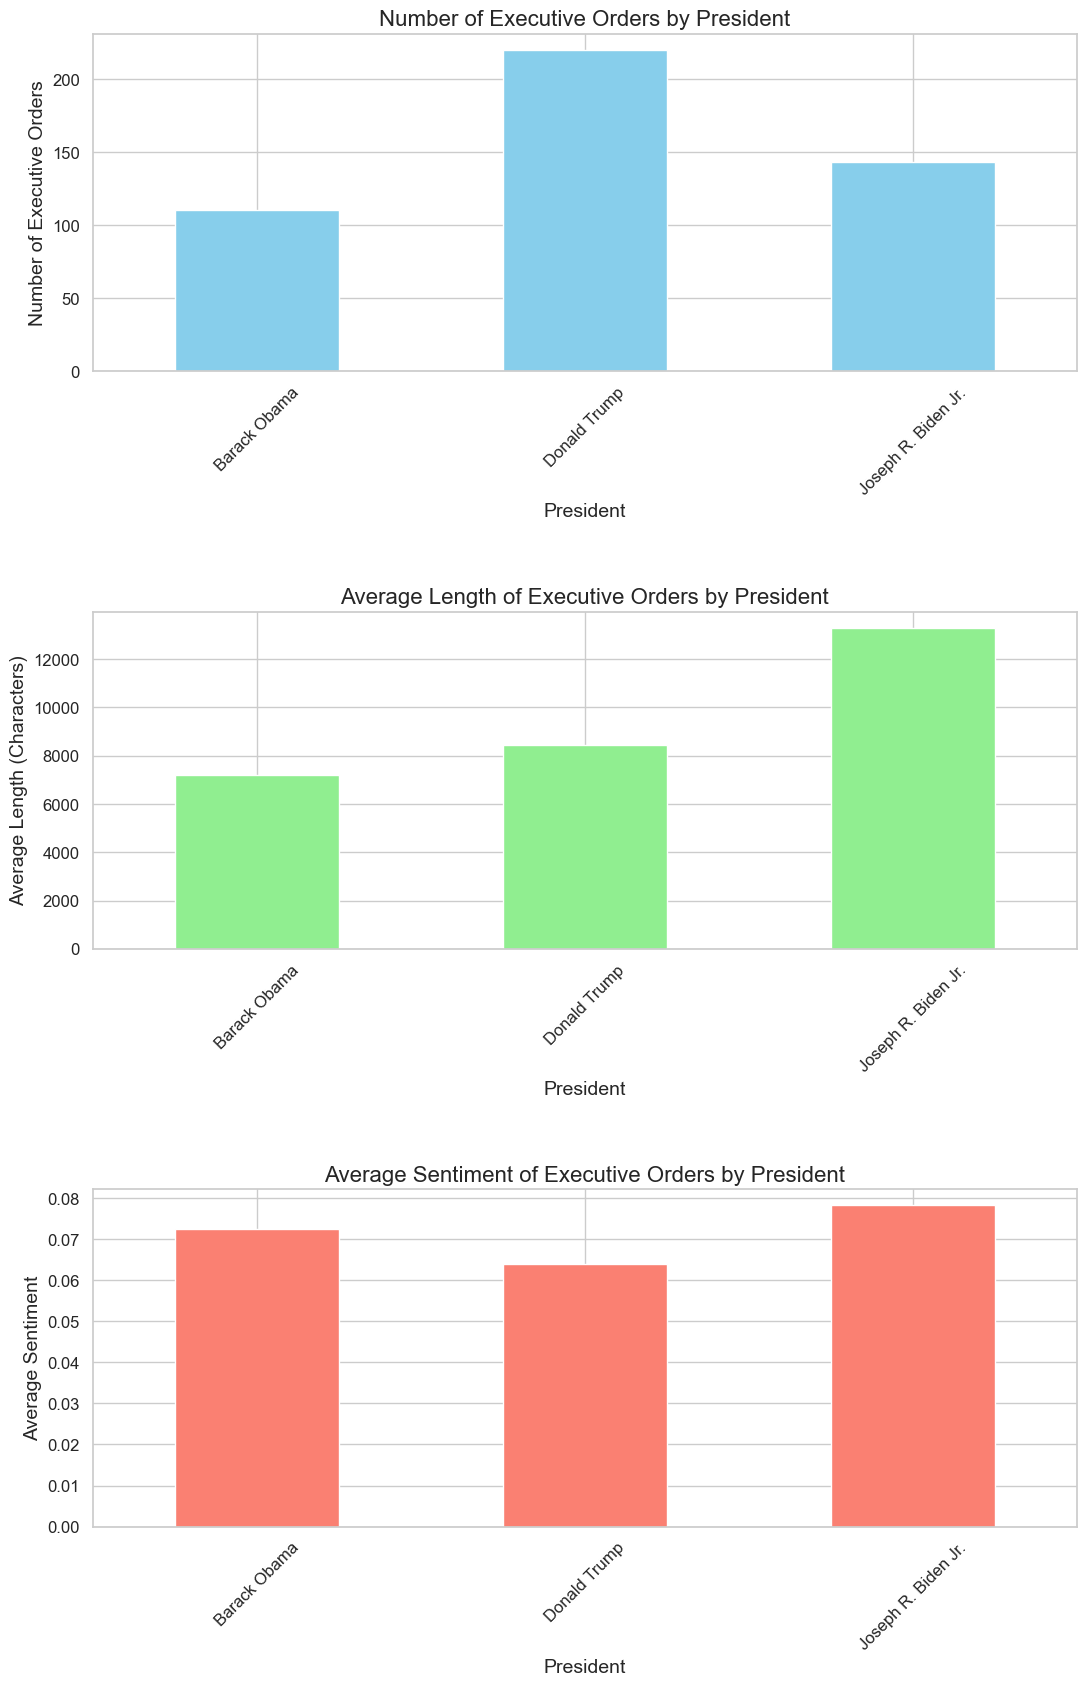

In [16]:
# Sentiment
sns.set(style="whitegrid")

# Define the order of presidents
order = ['Barack Obama', 'Donald Trump', 'Joseph R. Biden Jr.']
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Plot 1: Number of Executive Orders by President
president_counts = recent_10_years_data['president'].value_counts().reindex(order)
president_counts.plot(kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Number of Executive Orders by President', fontsize=16)
axs[0].set_xlabel('President', fontsize=14)
axs[0].set_ylabel('Number of Executive Orders', fontsize=14)
axs[0].tick_params(axis='x', rotation=45, labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Plot 2: Average Length of Executive Orders by President
average_length = recent_10_years_data.groupby('president')['text_length'].mean().reindex(order)
average_length.plot(kind='bar', color='lightgreen', ax=axs[1])
axs[1].set_title('Average Length of Executive Orders by President', fontsize=16)
axs[1].set_xlabel('President', fontsize=14)
axs[1].set_ylabel('Average Length (Characters)', fontsize=14)
axs[1].tick_params(axis='x', rotation=45, labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Plot 3: Average Sentiment of Executive Orders by President
recent_10_years_data['sentiment'] = recent_10_years_data['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
average_sentiment = recent_10_years_data.groupby('president')['sentiment'].mean().reindex(order)
average_sentiment.plot(kind='bar', color='salmon', ax=axs[2])
axs[2].set_title('Average Sentiment of Executive Orders by President', fontsize=16)
axs[2].set_xlabel('President', fontsize=14)
axs[2].set_ylabel('Average Sentiment', fontsize=14)
axs[2].tick_params(axis='x', rotation=45, labelsize=12)
axs[2].tick_params(axis='y', labelsize=12)

plt.tight_layout(pad=4)
plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/2232085549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['ai_related'] = recent_10_years_data['full_text'].apply(
/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/2232085549.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['year'] = pd.to_datetime(recent_10_years_data['signing_date']).dt.year


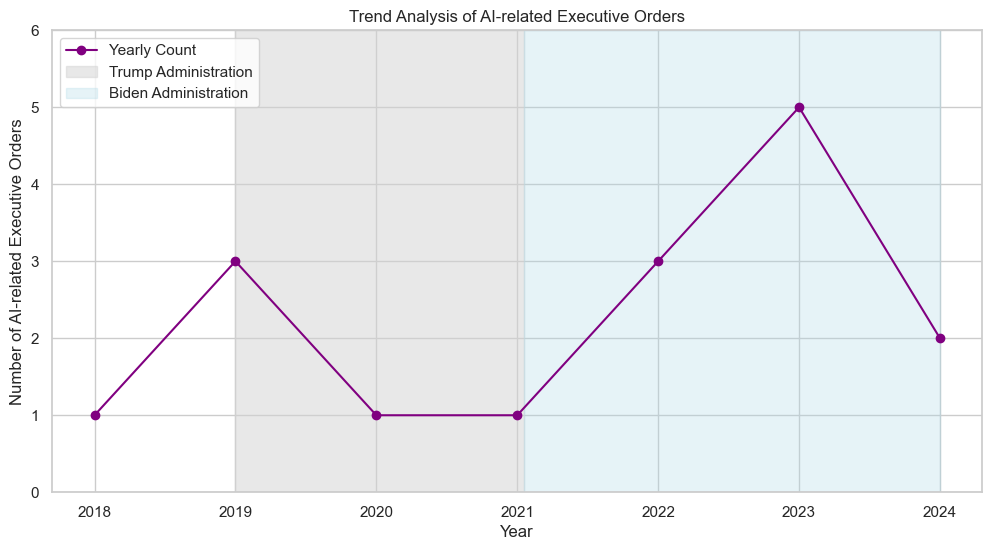

In [17]:
# AI-related Executive Orders
ai_keywords = ['artificial intelligence', 'AI']

recent_10_years_data['ai_related'] = recent_10_years_data['full_text'].apply(
    lambda x: any(keyword in str(x).lower() for keyword in ai_keywords)
)

# Count AI-related EOs per year
recent_10_years_data['year'] = pd.to_datetime(recent_10_years_data['signing_date']).dt.year
ai_eo_per_year = recent_10_years_data[recent_10_years_data['ai_related']].groupby('year').size()

# Plot the trend of AI-related Executive Orders with presidencies
plt.figure(figsize=(12, 6))
ai_eo_per_year.plot(kind='line', marker='o', color='purple', label='Yearly Count')

plt.title('Trend Analysis of AI-related Executive Orders')
plt.xlabel('Year')
plt.ylabel('Number of AI-related Executive Orders')
plt.grid(True)
plt.ylim(0, ai_eo_per_year.max() + 1)

plt.axvspan(2019, 2021.05, color='lightgrey', alpha=0.5, label='Trump Administration')
plt.axvspan(2021.05, 2024, color='lightblue', alpha=0.3, label='Biden Administration')

plt.legend()
plt.show()


/var/folders/fn/q1_rsjk92n3232jc85ymgdpm0000gn/T/ipykernel_4469/730213797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_10_years_data['ai_sentiment'] = recent_10_years_data['full_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if any(keyword in str(x).lower() for keyword in ai_keywords) else None)


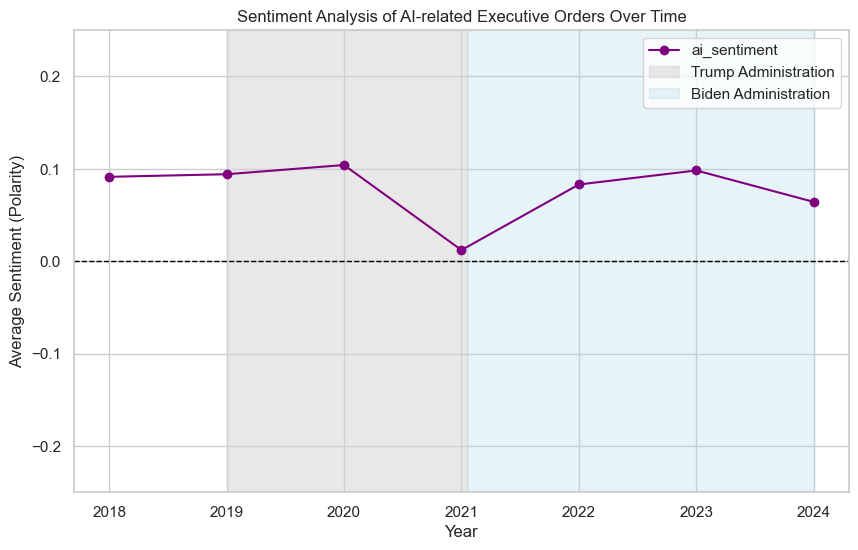

In [18]:
# Plot the sentiment of AI-related Executive Orders over the years
recent_10_years_data['ai_sentiment'] = recent_10_years_data['full_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if any(keyword in str(x).lower() for keyword in ai_keywords) else None)

plt.figure(figsize=(10, 6))
ai_sentiment_per_year = recent_10_years_data[recent_10_years_data['ai_sentiment'].notnull()].groupby('year')['ai_sentiment'].mean()
ax = ai_sentiment_per_year.plot(kind='line', marker='o', color='purple')

plt.title('Sentiment Analysis of AI-related Executive Orders Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment (Polarity)')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Highlight different presidencies
plt.axvspan(2019, 2021.05, color='lightgrey', alpha=0.5, label='Trump Administration')
plt.axvspan(2021.05, 2024, color='lightblue', alpha=0.3, label='Biden Administration')

ax.set_ylim(-0.25, 0.25)

plt.legend()
plt.show()


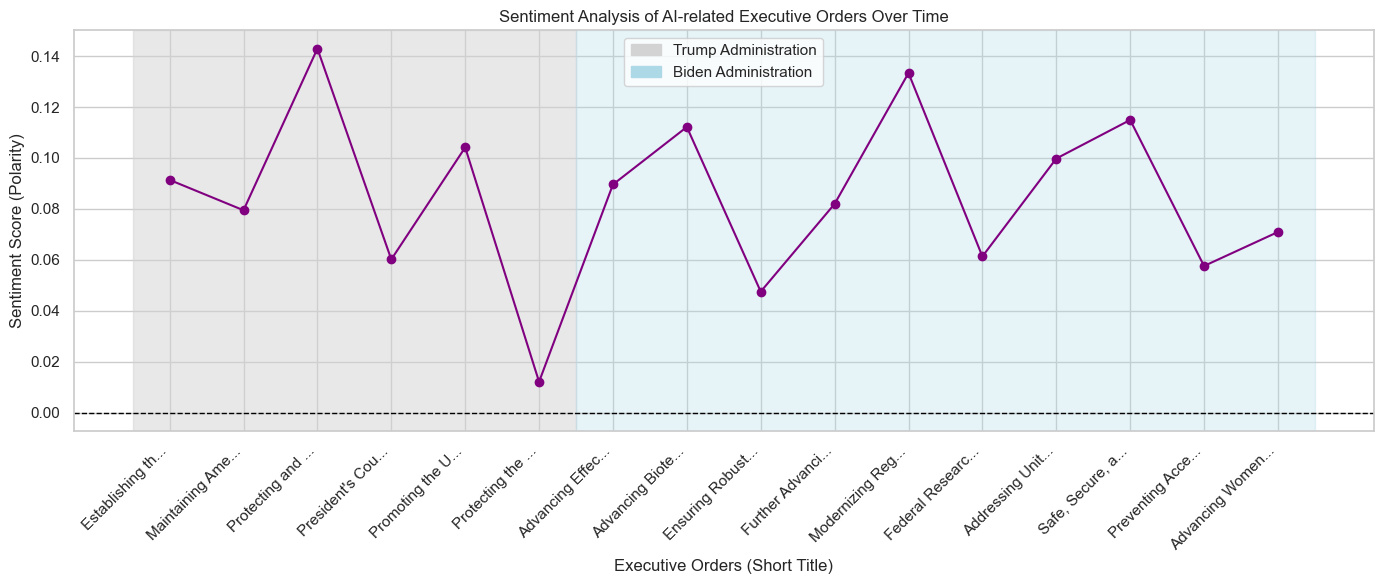

In [19]:
# Plot the sentiment scores
ai_related_eos = recent_10_years_data[recent_10_years_data['ai_related'] & recent_10_years_data['ai_sentiment'].notnull()]
ai_related_eos_sorted = ai_related_eos.sort_values(by='signing_date')

ai_related_eos_sorted['signing_date'] = pd.to_datetime(ai_related_eos_sorted['signing_date'])

ai_related_eos_sorted['president'] = ai_related_eos_sorted['signing_date'].apply(
    lambda date: 'Trump' if date < pd.to_datetime('2021-01-20') else 'Biden'
)

ai_related_eos_sorted['short_title'] = ai_related_eos_sorted['title'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)

# Plot each EO in chronological order with titles on the x-axis
plt.figure(figsize=(14, 6))

plt.axvspan(-0.5, len(ai_related_eos_sorted[ai_related_eos_sorted['president'] == 'Trump']) - 0.5, 
            color='lightgrey', alpha=0.5, label='Trump Administration')
plt.axvspan(len(ai_related_eos_sorted[ai_related_eos_sorted['president'] == 'Trump']) - 0.5, 
            len(ai_related_eos_sorted) - 0.5, 
            color='lightblue', alpha=0.3, label='Biden Administration')

plt.plot(ai_related_eos_sorted['short_title'], ai_related_eos_sorted['ai_sentiment'], marker='o', color='purple', linestyle='-')

plt.title('Sentiment Analysis of AI-related Executive Orders Over Time')
plt.xlabel('Executive Orders (Short Title)')
plt.ylabel('Sentiment Score (Polarity)')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Draw baseline at y=0
plt.xticks(rotation=45, ha='right')

trump_patch = mpatches.Patch(color='lightgrey', label='Trump Administration')
biden_patch = mpatches.Patch(color='lightblue', label='Biden Administration')
plt.legend(handles=[trump_patch, biden_patch])

plt.tight_layout()
plt.show()


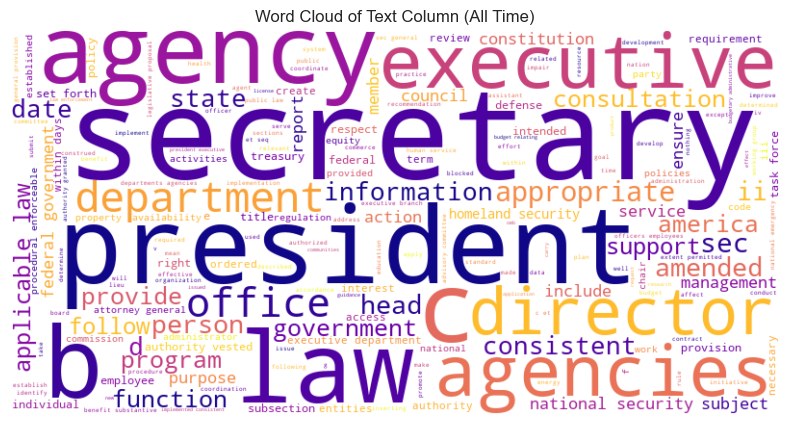

In [20]:
# List of additional stopwords, including both plural and singular, and variants
additional_stopwords = {
    "united states", "united state", "order", "executive order", "hereby", "section", 
    "act", "pursuant", "whereas", "thereof", "shall", "said", "s", "u", 
    "including", "use", "also", "may", "every", "either", "much", "must", 
    "need", "now", "often", "part", "put", "united", "states"
}

stopwords = set(STOPWORDS)
stopwords.update(additional_stopwords)

text_data = ' '.join(data['full_text'].dropna()).lower()

# Word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='plasma', 
    stopwords=stopwords
).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Column (All Time)')
plt.show()


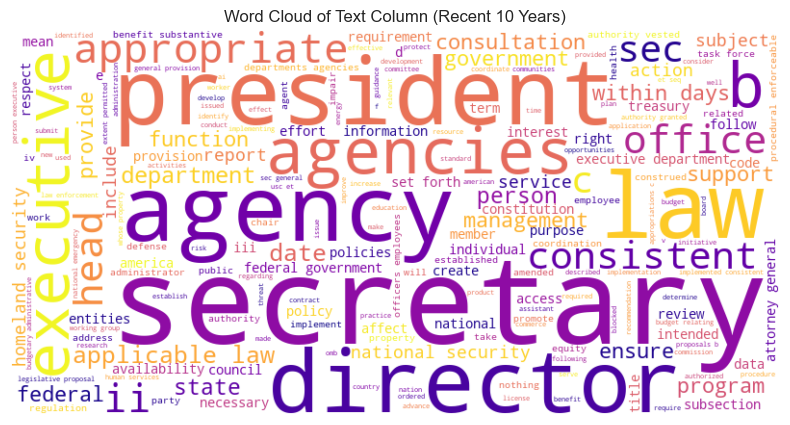

In [21]:
# Word Cloud of Text Column (Recent 10 Years)
text_data = ' '.join(recent_10_years_data['full_text'].dropna()).lower()

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='plasma', 
    stopwords=stopwords
).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Column (Recent 10 Years)')
plt.show()
